# Sandbox used for exploring data


In [4]:
%matplotlib inline

import datetime

import pandas as pd
import matplotlib.pyplot as plt

import config

from data.database import Database
from data.api_manager import API_Manager

db = Database(config.database)
api = API_Manager(config.api_key)

## Trades

### What time window should the target variable be reduced to?

The vast majority of trades happend within regular hours. Most price changes also happens within this time. Anything outside Robinhood's extended hours can easily be trimmed off.

The fastest changes happen at the scale of seconds, whereas slower changes happen at the scale of minutes. No large changes seem to happen at the timescale of millisecond, so a window of 1 second would probably suffice.

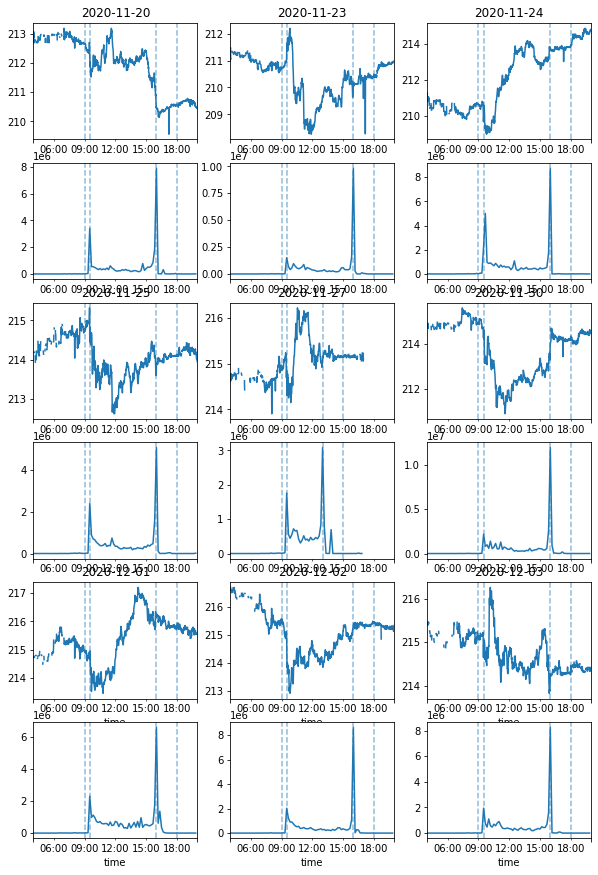

In [33]:
ticker = 'MSFT'
exchange = db.get_ticker_details(ticker)['exchange']

stored_dates = sorted(db.get_stored_dates('trades', ticker))

# Determine which hours the exchange is open, and which are before/after hours.
holidays = dict(db.get_holidays(exchange))
hours = {}
for date in stored_dates:
    hours[date] = {
        'open': datetime.time(9, 30), 
        'pre-open': datetime.time(9, 0),
        'close': datetime.time(16, 0),
        'post-close': datetime.time(18, 0),
    }
    if date in holidays and holidays[date] == 'half':
        hours[date]['close'] = datetime.time(13, 0)
        hours[date]['post-close'] = datetime.time(15, 0)



fig, axes = plt.subplots(6, 3, figsize=(10, 15))
for i in range(0, 9):
    date = stored_dates[len(stored_dates) - 10 + i]
    
    
    ax_price = axes[int(i/3)*2, i%3]
    ax_volume = axes[int(i/3)*2+1, i%3]
    
    trades = db.get_trades(ticker, date)
    trades = pd.DataFrame(trades, columns=['timestamp', 'price', 'volume'])
    trades['time'] = pd.to_datetime(trades['timestamp']) \
        .dt.tz_localize('UTC') \
        .dt.tz_convert('America/New_York') 
        
    
    trades.groupby(pd.Grouper(key='time', freq='1min'))['price'].mean().plot.line(ax=ax_price)
    trades.groupby(pd.Grouper(key='time', freq='10min'))['volume'].sum().plot.line(ax=ax_volume)
    
    ax_price.set_title(date)
    for ax in (ax_price, ax_volume):
        ax.set_xlim(
            datetime.datetime.combine(date, datetime.time(4, 0)),
            datetime.datetime.combine(date, datetime.time(20, 0)),
        )
        if i < 6:
            ax.set_xlabel('')
    
        for time in hours[date].values():
            ax.axvline(
                datetime.datetime.combine(date, time), 
                linestyle='--', alpha=0.5
            )

<AxesSubplot:xlabel='time'>

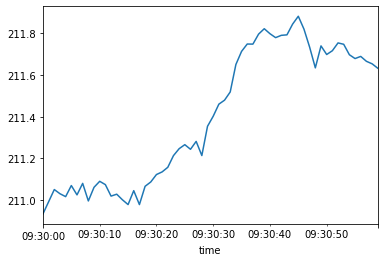

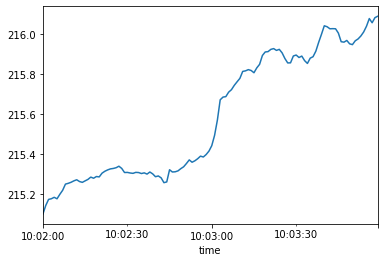

In [63]:
trades = db.get_trades(ticker, '2020-11-23')
trades = pd.DataFrame(trades, columns=['timestamp', 'price', 'volume'])
trades['time'] = pd.to_datetime(trades['timestamp']).dt.tz_localize('UTC').dt.tz_convert('America/New_York')

rise = trades
rise = rise[rise['time'].dt.time > datetime.time(9, 30)]
rise = rise[rise['time'].dt.time < datetime.time(9, 31)]
plt.figure()
rise.groupby(pd.Grouper(key='time', freq='1S'))['price'].mean().plot.line()


trades = db.get_trades(ticker, '2020-12-03')
trades = pd.DataFrame(trades, columns=['timestamp', 'price', 'volume'])
trades['time'] = pd.to_datetime(trades['timestamp']).dt.tz_localize('UTC').dt.tz_convert('America/New_York')

fall = trades
fall = fall[fall['time'].dt.time > datetime.time(10, 2)]
fall = fall[fall['time'].dt.time < datetime.time(10, 4)]
plt.figure()
fall.groupby(pd.Grouper(key='time', freq='1S'))['price'].mean().plot.line()